In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

In [17]:
#define the ticker symbol
tickerSymbol = 'TSLA'

In [18]:
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

In [19]:
#get the historical prices for this ticker
tickerDf = tickerData.history(interval='1d', start='2019-1-2', end='2020-4-10')

In [20]:
priceData = tickerDf.Open

In [21]:
priceData = priceData.asfreq(pd.infer_freq(priceData.index))

In [22]:
priceData

Date
2019-01-02     61.220001
2019-01-03     61.400002
2019-01-04     61.200001
2019-01-05           NaN
2019-01-06           NaN
                 ...    
2020-04-05           NaN
2020-04-06    102.239998
2020-04-07    109.000000
2020-04-08    110.839996
2020-04-09    112.417999
Freq: D, Name: Open, Length: 464, dtype: float64

Text(0.5, 1.0, 'TSLA Price Data')

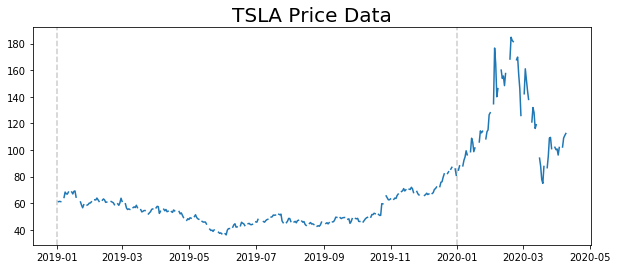

In [23]:
plt.figure(figsize=(10,4))
plt.plot(priceData)
for year in range(priceData.index[0].year, priceData.index[-1].year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.2)
plt.title("%s Price Data"%tickerSymbol, fontsize=20)

In [44]:
priceData.pct_change(),priceData.pct_change()[1:],priceData.pct_change()[1:]>0,priceData.pct_change()[1:]<0 #this series is sub_series

(Date
 2019-01-02         NaN
 2019-01-03    0.002940
 2019-01-04   -0.003257
 2019-01-05    0.000000
 2019-01-06    0.000000
                 ...   
 2020-04-05    0.000000
 2020-04-06    0.003337
 2020-04-07    0.066119
 2020-04-08    0.016881
 2020-04-09    0.014237
 Freq: D, Name: Open, Length: 464, dtype: float64,
 Date
 2019-01-03    0.002940
 2019-01-04   -0.003257
 2019-01-05    0.000000
 2019-01-06    0.000000
 2019-01-07    0.051373
                 ...   
 2020-04-05    0.000000
 2020-04-06    0.003337
 2020-04-07    0.066119
 2020-04-08    0.016881
 2020-04-09    0.014237
 Freq: D, Name: Open, Length: 463, dtype: float64,
 Date
 2019-01-03     True
 2019-01-04    False
 2019-01-05    False
 2019-01-06    False
 2019-01-07     True
               ...  
 2020-04-05    False
 2020-04-06     True
 2020-04-07     True
 2020-04-08     True
 2020-04-09     True
 Freq: D, Name: Open, Length: 463, dtype: bool,
 Date
 2019-01-03    False
 2019-01-04     True
 2019-01-05    False
 201

In [48]:
def get_buying_selling_days(price_data, b, s):
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    #this function checks the buying condition
    def buying_condition(sub_series):
        return (sub_series > 0).all()
    
    #this function checks the selling condition
    def selling_condition(sub_series):
        return (sub_series < 0).all()
    
    #get all buying days in the data
    buying_days = pct_change.rolling(b).apply(buying_condition)
    
    #get all potential selling days in the data
    potential_selling_days = pct_change.rolling(s).apply(selling_condition)
    
    #return a dictionary
    return {'buying_days': buying_days, 'potential_selling_days': potential_selling_days}


In [60]:
info_dit = get_buying_selling_days(priceData, 3, 1)

In [61]:
buying_days = info_dict['buying_days']
potential_selling_days = info_dict['potential_selling_days']

In [62]:
#create dataframe to store information
df_stocks = pd.DataFrame(index = buying_days.index)

In [63]:
#populate df with buying days, possible selling days, and price
df_stocks['buying_day'] = (buying_days == 1)
df_stocks['potential_selling_day'] = (potential_selling_days == 1)
df_stocks['price'] = priceData

#only keep days that are buying or possible selling days
df_stocks = df_stocks[(df_stocks.buying_day | df_stocks.potential_selling_day)]

In [64]:
buying_days == 1, potential_selling_days

(Date
 2019-01-03     True
 2019-01-04    False
 2019-01-05    False
 2019-01-06    False
 2019-01-07     True
               ...  
 2020-04-05    False
 2020-04-06     True
 2020-04-07     True
 2020-04-08     True
 2020-04-09     True
 Freq: D, Name: Open, Length: 463, dtype: bool,
 Date
 2019-01-03    0.0
 2019-01-04    1.0
 2019-01-05    0.0
 2019-01-06    0.0
 2019-01-07    0.0
              ... 
 2020-04-05    0.0
 2020-04-06    0.0
 2020-04-07    0.0
 2020-04-08    0.0
 2020-04-09    0.0
 Freq: D, Name: Open, Length: 463, dtype: float64)

In [29]:
df_stocks.head()

,buying_day,potential_selling_day,price
Date,,,
2019-01-03,True,False,61.400002
2019-01-04,False,True,61.200001
2019-01-07,True,False,64.344002
2019-01-08,True,False,68.391998
2019-01-09,False,True,67.099998


In [30]:
def check_cumulative_percent_change(price_data, buy_date, potential_sell_date):
    """
    This helper function will check if the cumulative percent change
    between a buying and potential selling day yields overall growth
    """
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    sub_series = 1 + pct_change[buy_date + timedelta(hours=1): potential_sell_date]

    return sub_series.product() > 1

In [69]:
df_stocks.price.pct_change()[1:]

Date
2019-01-04   -0.003257
2019-01-07    0.051373
2019-01-08    0.062912
2019-01-09   -0.018891
2019-01-10   -0.003279
                ...   
2020-04-03    0.059185
2020-04-06    0.003337
2020-04-07    0.066119
2020-04-08    0.016881
2020-04-09    0.014237
Name: price, Length: 319, dtype: float64

In [31]:
def get_investing_result(df_stocks, starting_funds, verbose=False):
    
    #get a copy of price data
    price_data = df_stocks.price
    
    #at start, not holding any shares
    holding = False
    
    #init vars
    current_funds = starting_funds
    current_shares = 0
    last_buy_date = None
    
    #init dict of buying and selling dates
    events_list = []
    
    #for each buying day and potential selling day...
    for date,data in df_stocks.iterrows():
        
        #if not currently holding shares, and this is a buying day...
        if (not holding) and data.buying_day:
            
            #calculate the number of shares we can buy
            num_shares_to_buy = int(current_funds / data.price)
            
            #update number of shares
            current_shares += num_shares_to_buy
            
            #decrease current funds
            current_funds -= num_shares_to_buy * data.price
            
            #set last buy date
            last_buy_date = date
            events_list.append(('b', date))
            
            #we are now holding shares
            holding = True
            
            if verbose:
                print('Bought %s shares at $%s on %s totaling $%s'%(num_shares_to_buy, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
        
        #if you are holding shares, and this is a potential selling day...
        elif holding and data.potential_selling_day:
            
            #check to make sure we're making a profit
            if check_cumulative_percent_change(price_data, last_buy_date, date):
                #add to our current funds
                current_funds += current_shares * data.price
                
                if verbose:
                    print('Sold %s shares at $%s on %s totaling $%s'%(current_shares, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
                    print('--------------------------------------')
                    
                #reset current shares
                current_shares = 0
                
                #we are no longer holding shares
                holding = False
                
                events_list.append(('s', date))
                
    #get the stock price at the end of the time span
    final_stock_price = price_data[-1]
        
    #get the final total value of all assets (funds + stock value)
    final_value = current_funds + final_stock_price * current_shares
    
    #return the percent change in value
    return round((final_value - starting_funds) / starting_funds,2), events_list


In [32]:
percent_change, events_list = get_investing_result(df_stocks, 10000, True)

Bought 162 shares at $61.400001525878906 on 2019-01-03 totaling $9946.8
Sold 162 shares at $67.0999984741211 on 2019-01-09 totaling $10870.2
--------------------------------------
Bought 159 shares at $68.41799926757812 on 2019-01-11 totaling $10878.46
Sold 159 shares at $69.22200012207031 on 2019-11-14 totaling $11006.3
--------------------------------------
Bought 157 shares at $70.12799835205078 on 2019-11-15 totaling $11010.1
Sold 157 shares at $70.3499984741211 on 2019-11-19 totaling $11044.95
--------------------------------------
Bought 153 shares at $72.0 on 2019-11-20 totaling $11016.0
Sold 153 shares at $85.75800323486328 on 2019-12-30 totaling $13120.97
--------------------------------------
Bought 155 shares at $84.9000015258789 on 2020-01-02 totaling $13159.5
Sold 155 shares at $88.09400177001953 on 2020-01-06 totaling $13654.57
--------------------------------------
Bought 148 shares at $92.27999877929688 on 2020-01-07 totaling $13657.44
Sold 148 shares at $96.35800170898

In [33]:
print(percent_change)

1.01


(34, 193)

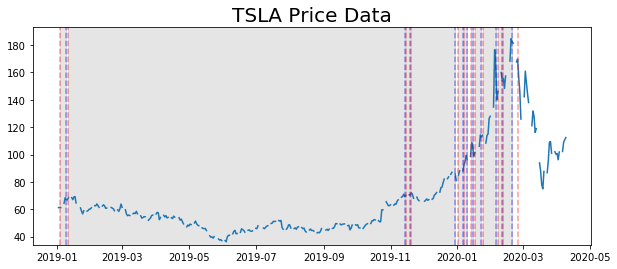

In [34]:
plt.figure(figsize=(10,4))
plt.plot(priceData)

y_lims = (int(priceData.min()*.95), int(priceData.max()*1.05))
shaded_y_lims = int(priceData.min()*.5), int(priceData.max()*1.5)

for idx, event in enumerate(events_list):
    color = 'red' if event[0] == 'b' else 'blue'
    plt.axvline(event[1], color=color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), 
                          event[1], events_list[idx-1][1], color='k', alpha=0.1)

plt.title("%s Price Data"%tickerSymbol, fontsize=20)
plt.ylim(*y_lims)